In [1]:
from scipy import signal
from scipy.io import wavfile
import numpy as np
import math
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import os
import pickle
%matplotlib inline
from matplotlib.colors import BoundaryNorm
sns.set_style("whitegrid")
colors = ["#1f77b4", "#ff7f0e", "#e377c2", "#bcbd22", "#7f7f7f", "#d62728", "#98df8a"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

In [3]:
#f = wavfile.read('dataset/0973.wav')

#f = wavfile.read('dataset/killdeer_song-mono.wav')
f = wavfile.read('dataset/horned_owl-mono.wav')


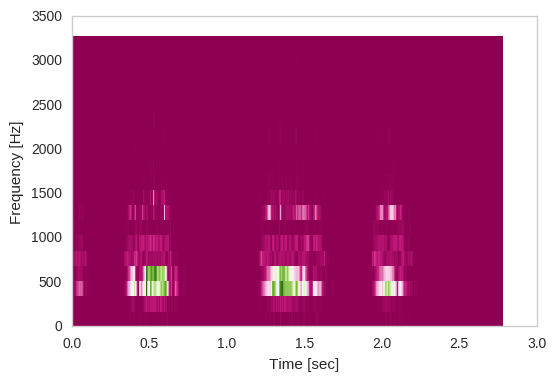

In [4]:
#f = wavfile.read('dataset/0564.wav')
s_orig_py = np.asarray(f[1],dtype=np.float64)
f, t, Sxx = signal.spectrogram(s_orig_py, f[0])


cmap = plt.get_cmap('PiYG')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(t, f[:20], Sxx[:20], cmap=cmap)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [5]:
np.shape(Sxx[:100])

(100, 548)

In [9]:
maxFreq = []
for i in range(np.shape(Sxx)[1]):
    maxFreq.append(np.max(Sxx[:,i]))

In [10]:
maxFreq = np.array(maxFreq)
maxFreq = maxFreq / 100000

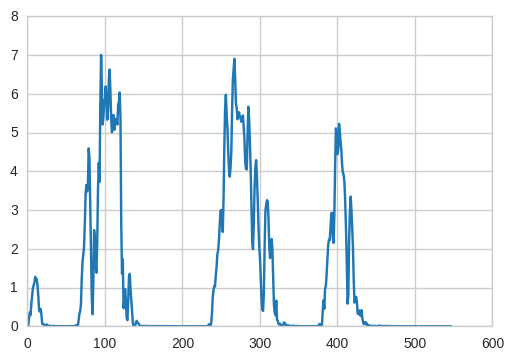

In [11]:
plt.plot(maxFreq)

In [15]:
M = np.matrix([[0.8, 0.1, 0.1],[0.1,0.8,0.1],[0.1, 0.1, 0.8]])
cpd = AndreasBayesFilterSOFT(2,np.matrix([[0.9, 0.1],[0.1, 0.9]]), means=[8,-1])#AndreasBayesFilterSOFT(3,M, means = [0,4,2])
z1,m1,v1, cp1 = cpd.run(maxFreq)

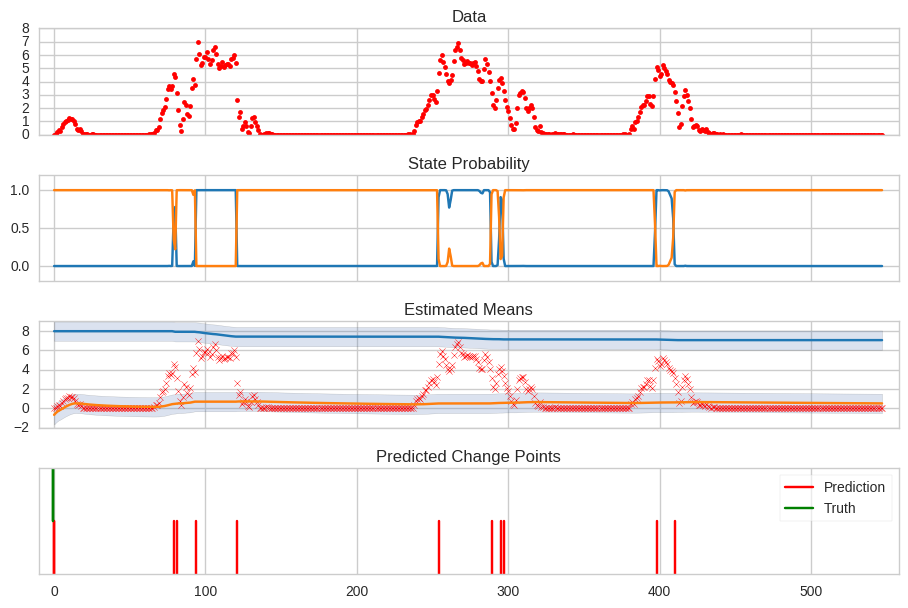

In [17]:
plotMultiStateParticleSub(maxFreq, z1, m1, v1, cp1, [0])

In [13]:

def plotMultiStateParticleSub(data, z, m, v, cp, trueCP):
    f, axarr = plt.subplots(4, sharex=True, figsize=(9, 6))
    axarr[0].set_xlim([-10,len(data)+10])
################ PREPARE DATA ################     
    states = len(z[0])
    zData = []
    meanData = []
    varData = []
    for i in range(states):
        zData.append(([],range(len(data))))
        meanData.append(([],range(len(data))))
        varData.append(([],range(len(data))))
    for t,z_t in enumerate(z):
        if len(z_t)>states:
            states += 1
            zData.append(([],range(t,len(data))))
            meanData.append(([],range(t,len(data))))
            varData.append(([],range(t,len(data))))
        for i,z_t_i in enumerate(z_t):
            zData[i][0].append(z_t_i)
            meanData[i][0].append(m[t][i])
            varData[i][0].append(v[t][i])
################ PLOT DATA ################ 
    axarr[0].plot(range(0,len(data)), data, 'r.')
    axarr[0].set_title("Data")
################ PLOT Z ################ 
    for z in zData:
        axarr[1].plot(z[1][:len(z[0])], z[0])
    axarr[1].set_ylim([-0.2,1.2])
    axarr[1].set_title("State Probability")
    axarr[1].set_yticks((0,0.5,1))
################ PLOT MEAN AND VAR################      
    for m, v in zip(meanData, varData):
        lowV = [mi-vi for (mi, vi) in zip(m[0],v[0])]
        highV = [mi+vi for (mi, vi) in zip(m[0],v[0])]
        axarr[2].plot(m[1][:len(m[0])], m[0])
        axarr[2].fill_between(m[1][:len(m[0])], lowV, highV, alpha=0.2)
    axarr[2].set_title("Estimated Means")
    axarr[2].set_ylim(min(data)-2, max(data)+2)
    axarr[2].scatter(range(0,len(data)), data, marker='x', color='red')
############### CHANGEPOINT ANALYSIS ##################
    for p in cp:
        axarr[3].axvline(x=p-1, ymin=0, ymax = 0.5, color='red', alpha=1.0)
    for p in trueCP:
        axarr[3].axvline(x=p-1, ymin=0.5, ymax = 1, color='green', alpha=1.0)
    axarr[3].axvline(x=cp[0]-1, ymin=0, ymax = 0.5, color='red', alpha=1.0, label='Prediction')
    axarr[3].axvline(x=trueCP[0]-1, ymin=0.5, ymax = 1, color='green', alpha=1.0, label='Truth')
    axarr[3].grid(axis='y')
    axarr[3].set_yticks(())
    axarr[3].set_title("Predicted Change Points")
    axarr[3].legend(frameon=True, framealpha=0.6)
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [14]:
class AndreasBayesFilterSOFT(object):   
    def __init__(self, n, M, means=[-1,1]):       
        self.M = M
        self.stateList = []
        self.prevZMax = -2
        for i in means:
            theta = [i,1]#TODO
            self.stateList.append(self.initState(1.0/n, theta))
        
    def initState(self, z, theta):
        return {'z':z, 'theta':theta, 'likelihood': [theta[0],1]}
        
    def computeTheta(self, _x, _theta, _z):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + _z) * (_z*_x + theta[0]/theta[1])
        return theta
    
    def update(self, _x): 
        zSum = 0
        zMax = 0
        zMaxIndex = -1
        for i,s in enumerate(self.stateList):
            likelihood = scipy.stats.norm(s['likelihood'][0], s['likelihood'][1]).pdf(_x)
            transitionProb = 0
            for k,j in enumerate(self.M[:,i]):
                sTemp = self.stateList[k]
                transitionProb +=  sTemp['z'] * j.item(0) * scipy.stats.norm(sTemp['theta'][0], sTemp['theta'][1]).pdf(sTemp['likelihood'][0])
            unnormZ = likelihood * transitionProb
            s['unnormZ'] = unnormZ
            zSum += unnormZ 
            if unnormZ > zMax:
                zMax = unnormZ
                zMaxIndex = i 
        #normalising z
        for s in self.stateList:
            s['z'] = s['unnormZ']/zSum
            #update state of zMax
            s['theta'] = self.computeTheta(_x, s['theta'], s['z'])
            s['likelihood'][0] = s['theta'][0]   
            
        z = [x['z'] for x in self.stateList]
        mean = [x['likelihood'][0] for x in self.stateList]
        var = [x['likelihood'][1] for x in self.stateList]
        cpbool = zMaxIndex != self.prevZMax
        self.prevZMax = zMaxIndex        
        return z, mean, var, cpbool
    
    def run(self,data):
        z = []
        mean = []
        var = []
        cp = []
        for t,d in enumerate(data):
            zi, mi, vari, cpbool = self.update(d)
            z.append(list(zi))
            mean.append(list(mi))
            var.append(list(vari))
            if cpbool:
                cp.append(t+1)
        return z, mean, var, cp
    
    def getBCPinfo(self):        
        return self.stateList[self.prevZMax]['theta'][0] 